# Visualize NWM



# 실행방법

```
docker run --rm -it --gpus '"device=1"' -p 8888:8888 -v "$PWD":/workspace/nwm nwm:cu126
```

docker run -it --name nwm_dev --gpus "device=1" -p 8888:8888 -v "$PWD":/workspace/nwm nwm:cu126

docker ps -a

docker stop nwm_dev

docker start -ai nwm_dev

docker start nwm_dev

docker exec -it nwm_dev bash

docker rm nwm_dev

docker rm -f nwm_dev


```
cd /workspace/nwm
jupyter notebook --ip 0.0.0.0 --port 8888 --no-browser --allow-root
```



## Load model


In [1]:
import yaml
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
from PIL import Image
import requests
from io import BytesIO
import numpy as np
from IPython.display import display, HTML
import ipywidgets as widgets
from diffusers.models import AutoencoderKL

from diffusion import create_diffusion
from isolated_nwm_infer import model_forward_wrapper
from misc import transform
from models import CDiT_models
from datasets import TrainingDataset

EXP_NAME = 'nwm_cdit_l'
MODEL_PATH = f'logs/{EXP_NAME}/checkpoints/cdit_l_100000.pth.tar'

with open("config/data_config.yaml", "r") as f:
    default_config = yaml.safe_load(f)
config = default_config

with open(f'config/{EXP_NAME}.yaml', "r") as f:
    user_config = yaml.safe_load(f)
config.update(user_config)
latent_size = config['image_size'] // 8

print("loading model")
model = CDiT_models[config['model']](input_size=latent_size, context_size=config['context_size'])
ckp = torch.load(MODEL_PATH, map_location='cpu', weights_only=False) 

print(model.load_state_dict(ckp["ema"], strict=True))
model.eval()
device = 'cuda:0'
model.to(device)
model = torch.compile(model)





loading model
<All keys matched successfully>


In [2]:
diffusion = create_diffusion(str(250))
# vae = AutoencoderKL.from_pretrained(f"stabilityai/sd-vae-ft-ema").to(device)
vae = AutoencoderKL.from_pretrained("logs/sd-vae-ft-ema").to(device)
latent_size = config['image_size'] // 8
print("latent_size", latent_size)

latent_size 28


## Choose starting image

In [ ]:
def url_to_pil_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return img

def load_internet_image(url):
    from torchvision import transforms
    _transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True),
    ])
    img = url_to_pil_image(url)
    x_start = _transform(img)
    return x_start.unsqueeze(0).expand(config['context_size'], x_start.shape[0], x_start.shape[1], x_start.shape[2])
    
# Jupyter Notebook Cell


# List of image links
# For unknown environments, please see https://github.com/facebookresearch/nwm/issues/7
image_links = [
    'https://raw.githubusercontent.com/amirbar/amirbar.github.io/refs/heads/master/images/recon.png',
    'https://raw.githubusercontent.com/amirbar/amirbar.github.io/refs/heads/master/images/scand.png',
    'https://raw.githubusercontent.com/amirbar/amirbar.github.io/refs/heads/master/images/sacson.png',
    'https://raw.githubusercontent.com/amirbar/amirbar.github.io/refs/heads/master/images/tartan.png'
]

# Output widget to hold the selected link
output = widgets.Output()
x_start_link = None  # This will hold the selected link

# Function to handle image click
def on_image_click(link):
    global x_start_link
    x_start_link = link
    with output:
        output.clear_output()
        print(f"Selected image link:\n{x_start_link}")

# Create HBox of images
image_buttons = []
for link in image_links:
    img = widgets.Button(
        description='click',
        layout=widgets.Layout(width='150px', height='20px', padding='0'),
        style={'button_color': 'lightgray'}
    )

    img._dom_classes += ('image-button',)
    img_link = link  # capture current link in closure

    def on_click(b, link=img_link):
        on_image_click(link)

    img.on_click(on_click)

    # Embed image using HTML style
    img_html = f'<img src="{link}" width="150px" height="150px">'
    img_html_widget = widgets.HTML(value=img_html)
    image_buttons.append(widgets.VBox([img_html_widget, img]))

# Display the gallery
display(widgets.HBox(image_buttons))
display(output)


Output()

## Visualize navigation commands

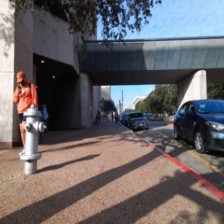

Output()

Button(description='Forward', style=ButtonStyle())

Button(description='Rotate Left', style=ButtonStyle())

Button(description='Rotate Right', style=ButtonStyle())

Button(description='Reset', style=ButtonStyle())

In [4]:
x_start = load_internet_image(x_start_link)

commands = {
    'Forward': [1,0,0],
    'Rotate Right': [0,0,-0.5],
    'Rotate Left': [0,0,0.5],
}
preds = {}

def reset():
    x_cond_pixels = x_start
    reconstructed_image=x_cond_pixels.to(device)
    preds['x_cond_pixels_display'] = (reconstructed_image[-1] * 127.5 + 127.5).clamp(0, 255).permute(1, 2, 0).to("cpu", dtype=torch.uint8).numpy()
    preds['x_cond_pixels'] = x_cond_pixels
    preds['video'] = [preds['x_cond_pixels_display']]
    

reset()
display(Image.fromarray(preds['x_cond_pixels_display']))
Image.fromarray(preds['x_cond_pixels_display']).save('sacson.png')

output = widgets.Output()
display(output)
rel_t = (torch.ones(1)*0.0078125).to(device)

@output.capture()
def update_image(b):
    
    if b.description == 'Reset':
        print("Reset clicked!")
        output.clear_output(wait=False)
        reset()
        return

    print("Button clicked!")
    y = commands[b.description]
    y = torch.tensor(y).to(device).unsqueeze(0)
    
    print("You entered:", b.description)
    x_cond_pixels = preds['x_cond_pixels'][-4:].unsqueeze(0).to(device)

    # --- GPU Resource Monitoring ---
    torch.cuda.reset_peak_memory_stats(device)
    torch.cuda.synchronize()
    mem_before = torch.cuda.memory_allocated(device)
    mem_reserved_before = torch.cuda.memory_reserved(device)
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    start_event.record()

    samples = model_forward_wrapper((model, diffusion, vae), x_cond_pixels, y, None, latent_size, device, config["context_size"], num_goals=1, rel_t=rel_t, progress=True)

    end_event.record()
    torch.cuda.synchronize()
    elapsed_ms = start_event.elapsed_time(end_event)
    mem_after = torch.cuda.memory_allocated(device)
    mem_reserved_after = torch.cuda.memory_reserved(device)
    mem_peak = torch.cuda.max_memory_allocated(device)
    total_mem = torch.cuda.get_device_properties(device).total_memory

    print(f"\n{'='*50}")
    print(f"  GPU Resource Usage ({torch.cuda.get_device_name(device)})")
    print(f"{'='*50}")
    print(f"  Inference time        : {elapsed_ms:.1f} ms ({elapsed_ms/1000:.2f} s)")
    print(f"  VRAM before inference  : {mem_before / 1024**2:.1f} MB")
    print(f"  VRAM after inference   : {mem_after / 1024**2:.1f} MB")
    print(f"  VRAM peak (allocated)  : {mem_peak / 1024**2:.1f} MB")
    print(f"  VRAM reserved (cache)  : {mem_reserved_after / 1024**2:.1f} MB")
    print(f"  VRAM total (device)    : {total_mem / 1024**2:.1f} MB")
    print(f"  VRAM peak usage ratio  : {mem_peak / total_mem * 100:.1f}%")
    print(f"  Delta (alloc)          : {(mem_after - mem_before) / 1024**2:+.1f} MB")
    print(f"{'='*50}\n")
    # --- End GPU Resource Monitoring ---

    x_cond_pixels = samples # torch.clip(samples, -1., 1.)
    preds['x_cond_pixels'] = torch.cat([preds['x_cond_pixels'].to(x_cond_pixels), x_cond_pixels], dim=0)
    samples = (samples * 127.5 + 127.5).permute(0, 2, 3, 1).clamp(0,255).to("cpu", dtype=torch.uint8).numpy()
    display(Image.fromarray(samples[0]))
    preds['video'].append(samples[0])

buttons = []
for o in ["Forward", "Rotate Left", "Rotate Right", "Reset"]:
    b = widgets.Button(description=o)
    b.on_click(update_image)
    display(b)
    buttons.append(b)

## Visualize latent vectors before and after action

Encode the current observation to VAE latent space, apply different navigation actions through the CDiT model, and compare the input vs output latent representations.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# ---------------------------------------------------------------
# Helper: run model and return both input & output latent tensors
# ---------------------------------------------------------------
@torch.no_grad()
def model_forward_with_latents(all_models, curr_obs, curr_delta, num_timesteps,
                               latent_size, device, num_cond, num_goals=1, rel_t=None):
    """
    Same as model_forward_wrapper but also returns:
      - input_latent  : VAE-encoded observation latent  (B, 4, H/8, W/8)
      - output_latent : diffusion-denoised output latent (B*num_goals, 4, H/8, W/8)
    """
    model, diffusion, vae = all_models

    x = curr_obs.to(device)
    y = curr_delta.to(device)

    with torch.amp.autocast('cuda', enabled=True, dtype=torch.bfloat16):
        B, T = x.shape[:2]

        if rel_t is None:
            rel_t = (torch.ones(B) * (1. / 128.)).to(device)
            rel_t *= num_timesteps

        x = x.flatten(0, 1)
        x = vae.encode(x).latent_dist.sample().mul_(0.18215).unflatten(0, (B, T))

        # ---- input latent: last conditioning frame ----
        input_latent = x[:, -1].clone().float()          # (B, 4, h, w)

        x_cond = x[:, :num_cond].unsqueeze(1).expand(
            B, num_goals, num_cond, x.shape[2], x.shape[3], x.shape[4]
        ).flatten(0, 1)

        z = torch.randn(B * num_goals, 4, latent_size, latent_size, device=device)
        y = y.flatten(0, 1)
        model_kwargs = dict(y=y, x_cond=x_cond, rel_t=rel_t)

        output_latent = diffusion.p_sample_loop(
            model.forward, z.shape, z,
            clip_denoised=False, model_kwargs=model_kwargs,
            progress=False, device=device
        )

        # ---- output latent (before VAE decode) ----
        output_latent_float = output_latent.clone().float()  # (B*num_goals, 4, h, w)

        # decode to pixels
        samples = vae.decode(output_latent / 0.18215).sample
        samples = torch.clip(samples, -1., 1.)

    return samples, input_latent.cpu(), output_latent_float.cpu()


# ---------------------------------------------------------------
# Run: encode observation, apply 3 actions, collect latents
# ---------------------------------------------------------------
x_obs = preds['x_cond_pixels'][-config['context_size']:].unsqueeze(0).to(device)

actions = {
    'Forward':      torch.tensor([[1.0, 0.0, 0.0]]),
    'Rotate Left':  torch.tensor([[0.0, 0.0, 0.5]]),
    'Rotate Right': torch.tensor([[0.0, 0.0, -0.5]]),
}
rel_t_vis = (torch.ones(1) * 0.0078125).to(device)

results = {}
for name, act in actions.items():
    act = act.to(device)
    pixels, in_lat, out_lat = model_forward_with_latents(
        (model, diffusion, vae), x_obs, act, None,
        latent_size, device, config['context_size'],
        num_goals=1, rel_t=rel_t_vis
    )
    results[name] = {
        'pixels': pixels,
        'input_latent': in_lat[0],    # (4, h, w)
        'output_latent': out_lat[0],  # (4, h, w)
    }

print(f"Latent shape: {results['Forward']['input_latent'].shape}")
print("Done — latents collected for Forward / Rotate Left / Rotate Right")

# ---------------------------------------------------------------
# Also encode the current observation image for the top row
# ---------------------------------------------------------------
with torch.no_grad():
    obs_for_encode = preds['x_cond_pixels'][-1:].unsqueeze(0).to(device)
    with torch.amp.autocast('cuda', enabled=True, dtype=torch.bfloat16):
        obs_latent = vae.encode(obs_for_encode.flatten(0, 1)).latent_dist.sample().mul_(0.18215)
    obs_latent = obs_latent[0].float().cpu()  # (4, h, w)

obs_pixel_display = preds['x_cond_pixels_display']  # already uint8 numpy


# ---------------------------------------------------------------
# Per-channel heatmap: current obs (top) + each action result
# ---------------------------------------------------------------
action_names = list(results.keys())
n_channels = 4
n_rows = 1 + len(action_names)  # 1 for current obs + 3 for actions
cols_per_row = n_channels * 2 + 1  # image + (output ch + diff ch) * 4
# For the current-obs row: image + 4 input-latent channels

fig = plt.figure(figsize=(22, 4 * n_rows + 2))
outer = gridspec.GridSpec(n_rows, 1, hspace=0.40, figure=fig)

# -- Shared color range across all latents for consistent comparison --
all_lats = [obs_latent.numpy()] + [results[n]['output_latent'].numpy() for n in action_names]
vmin_global = min(l.min() for l in all_lats)
vmax_global = max(l.max() for l in all_lats)

# ===================== Row 0: Current observation =====================
inner0 = gridspec.GridSpecFromSubplotSpec(
    1, 1 + n_channels, subplot_spec=outer[0], wspace=0.15
)
ax_obs = fig.add_subplot(inner0[0])
ax_obs.imshow(obs_pixel_display)
ax_obs.set_title('Current Obs\n(pixel)', fontsize=9, fontweight='bold')
ax_obs.axis('off')

in_lat_np = obs_latent.numpy()
for ch in range(n_channels):
    ax_ch = fig.add_subplot(inner0[1 + ch])
    ax_ch.imshow(in_lat_np[ch], cmap='viridis', vmin=vmin_global, vmax=vmax_global)
    ax_ch.set_title(f'Input latent ch{ch}', fontsize=8)
    ax_ch.axis('off')

# ===================== Rows 1-3: Each action result =====================
for row_idx, name in enumerate(action_names):
    out_lat = results[name]['output_latent'].numpy()
    diff    = out_lat - in_lat_np

    inner = gridspec.GridSpecFromSubplotSpec(
        1, 1 + n_channels * 2, subplot_spec=outer[1 + row_idx],
        wspace=0.15
    )

    # decoded pixel preview
    ax_img = fig.add_subplot(inner[0])
    pix = results[name]['pixels'][0].detach().cpu()
    pix = ((pix * 0.5 + 0.5) * 255).clamp(0, 255).permute(1, 2, 0).to(torch.uint8).numpy()
    ax_img.imshow(pix)
    ax_img.set_title(f'{name}\n(decoded)', fontsize=9, fontweight='bold')
    ax_img.axis('off')

    for ch in range(n_channels):
        # Output latent channel
        ax_out = fig.add_subplot(inner[1 + ch * 2])
        ax_out.imshow(out_lat[ch], cmap='viridis', vmin=vmin_global, vmax=vmax_global)
        ax_out.set_title(f'Output ch{ch}', fontsize=7)
        ax_out.axis('off')

        # Difference (output - input)
        ax_diff = fig.add_subplot(inner[1 + ch * 2 + 1])
        d_abs = max(abs(diff[ch].min()), abs(diff[ch].max()))
        ax_diff.imshow(diff[ch], cmap='RdBu_r',
                       vmin=-d_abs if d_abs > 0 else -1,
                       vmax=d_abs if d_abs > 0 else 1)
        ax_diff.set_title(f'Diff ch{ch}', fontsize=7)
        ax_diff.axis('off')

fig.suptitle(
    'Latent comparison — Row 1: Current observation input latent\n'
    'Rows 2-4: Output latent & Difference (output − input) per action',
    fontsize=13, y=1.02
)
plt.savefig('latent_channel_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: latent_channel_comparison.png")

# Generate a video

In [5]:

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import numpy as np
# np array with shape (frames, height, width, channels)
video = np.array(preds['video']) 

fig = plt.figure()
im = plt.imshow(video[0,:,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=500)
HTML(anim.to_html5_video())


In [ ]:
# optional: load from dataset
# dataloaders = {}

# for dataset_name in config["datasets"]:
#     data_config = config["datasets"][dataset_name]
#     for data_split_type in ["test"]: #["test"]:
#         dataset = TrainingDataset(
#             data_folder=data_config["data_folder"],
#             data_split_folder=data_config[data_split_type],
#             dataset_name=dataset_name,
#             image_size=config["image_size"],
#             min_dist_cat=config["distance"]["min_dist_cat"],
#             max_dist_cat=config["distance"]["max_dist_cat"],
#             len_traj_pred=config["len_traj_pred"],
#             context_size=config["context_size"],
#             normalize=config["normalize"],
#             goals_per_obs=1,
#             transform=transform,
#             predefined_index=None,
#             traj_stride=1,
#         )
#         dataloaders[f"{dataset_name}_{data_split_type}"] = dataset
#         print(f"Dataset: {dataset_name} ({data_split_type}), size: {len(dataset)}")

# load from dataset
# ds = dataloaders['recon_test'] # scand_test, 
# x, _, _ = ds[np.random.randint(len(ds))]
# x_start = x[:config["context_size"]]
